# <b><u>PCA, DTW, and Socket Programming</u></b>

  The data is collected from a SENSOR LOGGER App from mobile. The sensor used is accelerometer. A reference data (accelerometerref.csv) is collected when a person was moving uniformly without any distraction. An original data (accelerometer.csv) was collected when the person received call 2 times during his walk and rotated his direction in between the time period, also, came to sit in a chair at the end of the time period. The whole system is trained to detect the anomaly in the original data. </b>

# 2.1 Socket Programming with Data Buffering

 The data is collected by using Flask framework. For Demonstration purpose, data is collected from 2 sensors --> Gyroscope and Accelerometer. Its written to file named "gyroscope.csv" and "accelerometer.csv" respectively. </b>

In [1]:
import dash
from dash.dependencies import Output, Input
from dash import dcc, html, dcc
from datetime import datetime
import json
import plotly.graph_objs as go
from collections import deque
from flask import Flask, request
import threading
import time

server = Flask(__name__)
app = dash.Dash(__name__, server=server)

MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

MAX_BUFFER_SIZE = 5000



buffer_data = deque(maxlen=MAX_BUFFER_SIZE)

batch_data = deque(maxlen=MAX_BUFFER_SIZE)

time_data = deque(maxlen=MAX_DATA_POINTS)
accel_x = deque(maxlen=MAX_DATA_POINTS)
accel_y = deque(maxlen=MAX_DATA_POINTS)
accel_z = deque(maxlen=MAX_DATA_POINTS)



time_data_gyro = deque(maxlen=MAX_DATA_POINTS)
gyro_x = deque(maxlen=MAX_DATA_POINTS)
gyro_y = deque(maxlen=MAX_DATA_POINTS)
gyro_z = deque(maxlen=MAX_DATA_POINTS)





app.layout = html.Div(children=[
    # All elements from the top of the page
    html.Div(
    [
        dcc.Markdown(
            children="""
            # Live Sensor Accelerometer
            Streamed from Sensor Logger: tszheichoi.com/sensorlogger
            """
        ),
        dcc.Graph(id="live_graph"),
        dcc.Interval(id="counter", interval=UPDATE_FREQ_MS),
    ]),
    # New Div for all elements in the new 'row' of the page
    html.Div(
    [
        dcc.Markdown(
            children="""
            # Live Sensor Gyroscope
            """
        ),
        dcc.Graph(id="live_graph1"),
        dcc.Interval(id="counter1", interval=UPDATE_FREQ_MS),
    ]),
])




@app.callback(Output("live_graph", "figure"), Input("counter", "n_intervals"))
def update_graph(_counter):
    data = [
        go.Scatter(x=list(time_data), y=list(d), name=name)
        for d, name in zip([accel_x, accel_y, accel_z], ["X", "Y", "Z"])
    ]

    graph = {
        "data": data,
        "layout": go.Layout(
            {
                "xaxis": {"type": "date"},
                "yaxis": {"title": "Acceleration ms<sup>-2</sup>"},
            }
        ),
    }
    if (
        len(time_data) > 0
    ):  #  cannot adjust plot ranges until there is at least one data point
        graph["layout"]["xaxis"]["range"] = [min(time_data), max(time_data)]
        graph["layout"]["yaxis"]["range"] = [
            min(accel_x + accel_y + accel_z),
            max(accel_x + accel_y + accel_z),
        ]

    return graph



@app.callback(Output("live_graph1", "figure"), Input("counter1", "n_intervals"))
def update_graph(_counter):
    data = [
        go.Scatter(x=list(time_data_gyro), y=list(d), name=name)
        for d, name in zip([gyro_x, gyro_y, gyro_z], ["X", "Y", "Z"])
    ]

    graph = {
        "data": data,
        "layout": go.Layout(
            {
                "xaxis": {"type": "date"},
                "yaxis": {"title": "Acceleration ms<sup>-2</sup>"},
            }
        ),
    }
    if (
        len(time_data_gyro) > 0
    ):  #  cannot adjust plot ranges until there is at least one data point
        graph["layout"]["xaxis"]["range"] = [min(time_data_gyro), max(time_data_gyro)]
        graph["layout"]["yaxis"]["range"] = [
            min(gyro_x + gyro_y + gyro_z),
            max(gyro_x + gyro_y + gyro_z),
        ]

    return graph



def process_batch_item(messsage):
    
    messsage = messsage.replace("'", '"')
    
    #print("&&&&&&&&&&&&&&&&&&&&&&&&")
    #print('{}'.format(messsage))
    #print("&&&&&&&&&&&&&&&&&&&&&&&&")
    data = json.loads(messsage)
    gyro_sub = []
    accel_sub = []
    
        
    for d in data['payload']:
        if ( d.get("name", None) == "accelerometer"):
            ts = datetime.fromtimestamp(d["time"] / 1000000000)
            x = d["values"]["x"]
            y = d["values"]["y"]
            z = d["values"]["z"]
            #print('{},{},{},{}'.format(ts,x,y,z))
            row = '{},{},{},{}'.format(ts,x,y,z)
            accel_sub.append(row)

        
    for d in data['payload']:
        if ( d.get("name", None) == "gyroscope"):
            ts = datetime.fromtimestamp(d["time"] / 1000000000)
            x = d["values"]["x"]
            y = d["values"]["y"]
            z = d["values"]["z"]
            #print('{},{},{},{}'.format(ts,x,y,z))
            row = '{},{},{},{}'.format(ts,x,y,z)
            gyro_sub.append(row) 
            
    return accel_sub, gyro_sub



def process_buffer_data(buffer_data):
    
    gyro_list = []
    accel_list = []


    while buffer_data:
        #print('{}'.format(buffer_data[0]))
        a_sub, g_sub = process_batch_item(str(buffer_data[0]))

        accel_list.extend(a_sub)
        gyro_list.extend(g_sub)

        buffer_data.popleft()



    with open('accelerometer.csv','w') as file:
        file.write('time,x_value,y_value,z_value')
        file.write('\n')

        for i in accel_list:
            file.write(i)
            file.write('\n')



    with open('gyroscope.csv','w') as file:
        file.write('time,x_value,y_value,z_value')
        file.write('\n')  

        for i in gyro_list:
            file.write(i)
            file.write('\n')
    
    



# Function to copy n items from source to destination deque 
def copy_data_interval(interval, m):
    
    #print("******Thread Started*******")
    while True:
        items_copied = []
        
        n = len(buffer_data)
        
        if(n>4):
            #print("---------")
            #print('Number of items on batch: {}'.format(n))

            for _ in range(n):
                if buffer_data:
                    data = buffer_data.popleft()
                    items_copied.append(data)
                else:
                    break
        
        if items_copied:
            #print("-----Inside items copied----")
            
            batch_data.clear()
            
            batch_data.extend(items_copied)
            #print(f"Copied {len(items_copied)} items: {items_copied}")
            process_buffer_data(batch_data)
            
        else:
            #print("Source deque is empty. Waiting...")
            time.sleep(interval)



@server.route("/data", methods=["POST"])
def data():  # listens to the data streamed from the sensor logger
    if str(request.method) == "POST":
        #print(request.data)
        data = json.loads(request.data)
        buffer_data.append(data)
        for d in data['payload']:
            if ( d.get("name", None) == "accelerometer"): 
                ts = datetime.fromtimestamp(d["time"] / 1000000000)
                if len(time_data) == 0 or ts > time_data[-1]:
                    time_data.append(ts)
                    
                    accel_x.append(d["values"]["x"])
                    accel_y.append(d["values"]["y"])
                    accel_z.append(d["values"]["z"])
                    
            elif ( d.get("name", None) == "gyroscope"):
                ts = datetime.fromtimestamp(d["time"] / 1000000000)
                if len(time_data_gyro) == 0 or ts > time_data_gyro[-1]:
                    time_data_gyro.append(ts)
                    
                    gyro_x.append(d["values"]["x"])
                    gyro_y.append(d["values"]["y"])
                    gyro_z.append(d["values"]["z"])
                    
                    
                    
    return "success"


if __name__ == "__main__":
    
    
    # Define the interval (in seconds) and the number of items to copy in each interval
    copy_interval = 60  # Adjust as needed
    items_to_copy = 3  # Adjust as needed

    # Create a thread to copy data at the specified interval
    copy_thread = threading.Thread(target=copy_data_interval, args=(copy_interval, items_to_copy))
    copy_thread.daemon = True
    copy_thread.start()
    
    app.run_server(port=8000, host="0.0.0.0")

Dash is running on http://0.0.0.0:8000/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://172.31.210.152:8000
Press CTRL+C to quit
172.31.204.101 - - [18/Oct/2023 01:58:54] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:58:55] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:58:55] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:58:56] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:58:57] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:58:58] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:58:59] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:59:00] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:59:01] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:59:02] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:59:03] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/Oct/2023 01:59:04] "POST /data HTTP/1.1" 200 -
172.31.204.101 - - [18/O

### -- <i>Visualizing reference data collected</i>

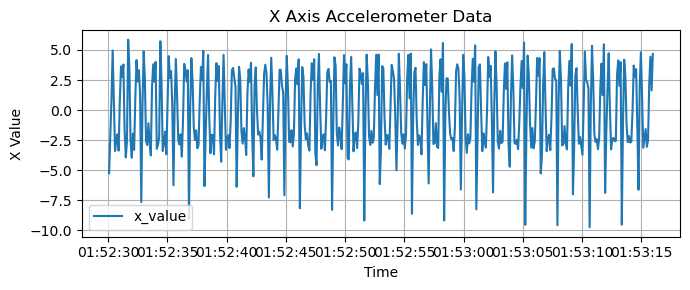

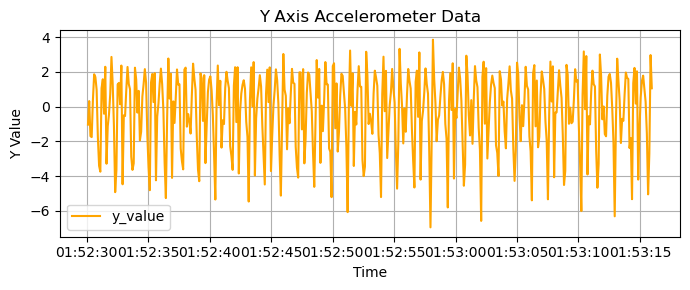

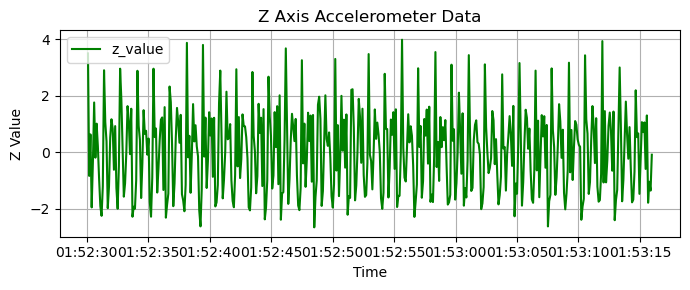

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('accelerometerref.csv', parse_dates=['time'])

# Plot x_value
plt.figure(figsize=(7,3))
plt.plot(df['time'], df['x_value'], label='x_value')
plt.title('X Axis Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('X Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot y_value
plt.figure(figsize=(7,3))
plt.plot(df['time'], df['y_value'], color='orange', label='y_value')
plt.title('Y Axis Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('Y Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot z_value
plt.figure(figsize=(7,3))
plt.plot(df['time'], df['z_value'], color='green', label='z_value')
plt.title('Z Axis Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('Z Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### -- <i>Visualizing Original data collected</i>

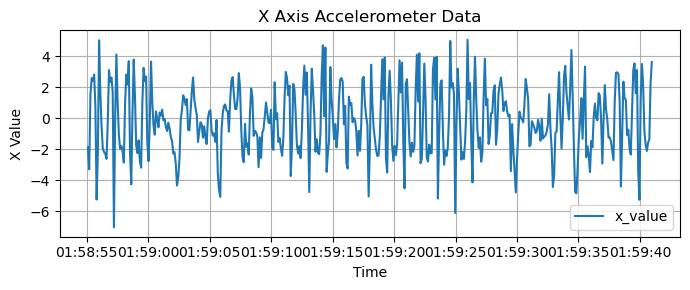

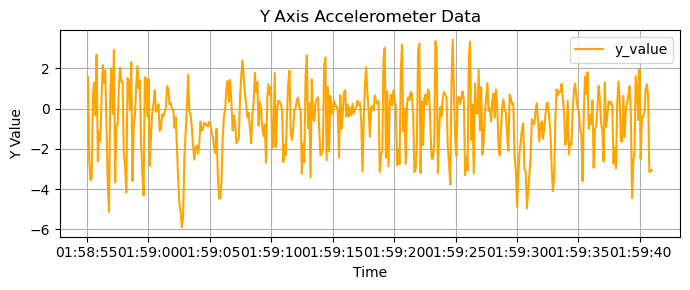

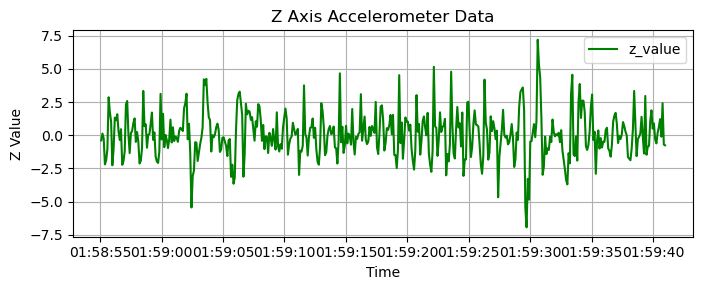

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('accelerometer.csv', parse_dates=['time'])

# Plot x_value
plt.figure(figsize=(7,3))
plt.plot(df['time'], df['x_value'], label='x_value')
plt.title('X Axis Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('X Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot y_value
plt.figure(figsize=(7,3))
plt.plot(df['time'], df['y_value'], color='orange', label='y_value')
plt.title('Y Axis Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('Y Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot z_value
plt.figure(figsize=(7,3))
plt.plot(df['time'], df['z_value'], color='green', label='z_value')
plt.title('Z Axis Accelerometer Data')
plt.xlabel('Time')
plt.ylabel('Z Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#  2.3 Dynamic Time Warping (DTW) with Early Abandoning
### <i>-- Loading Data from our reference file and original file</i>


In [58]:
import pandas as pd

# Load the datasets
ref_data = pd.read_csv('accelerometerref.csv')
test_data = pd.read_csv('accelerometer.csv')


### -- <i>Creating a function to perform dtw with Early Abandoning</i>

In [59]:
import numpy as np



def dtw_distance(ts1, ts2, threshold=float(50)):
    DTW = {}
    
    w = max(len(ts1), len(ts2))
    for i in range(-1, len(ts1)):
        for j in range(-1, len(ts2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j])**2
            smallest_previous = min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
            
            #Implementing Early Abandoning to improve Efficiency
            if smallest_previous > threshold:
                return float('inf')
            
            DTW[(i, j)] = dist + smallest_previous
    
    return np.sqrt(DTW[len(ts1)-1, len(ts2)-1])







### -- <i>Compute DTW distances for all windows</i>

In [60]:
# Define a window size and step size for sliding window
window_size = 3
step_size = 1  


dtw_features = []

for start in range(0, len(test_data) - window_size + 1, step_size):
    window_ref = ref_data.iloc[start:start+window_size].reset_index(drop=True)
    window_test = test_data.iloc[start:start+window_size].reset_index(drop=True)
    
    dtw_x = dtw_distance(window_ref['x_value'], window_test['x_value'])
    dtw_y = dtw_distance(window_ref['y_value'], window_test['y_value'])
    dtw_z = dtw_distance(window_ref['z_value'], window_test['z_value'])
    
    dtw_features.append([dtw_x, dtw_y, dtw_z])

In [61]:
#  Replace infinity values for calculation purpose.
dtw_features = np.array(dtw_features)
dtw_features[np.isinf(dtw_features)] = np.nanmax(dtw_features[~np.isinf(dtw_features)])


In [62]:
print((dtw_features))

[[ 3.59254273  3.52796674  4.03770663]
 [ 2.68668125  3.80557358  1.32387715]
 [ 3.04484418  2.51801689  1.80685662]
 ...
 [ 6.8570902   4.06733839  3.8417618 ]
 [12.59054402  8.37528236  3.89662488]
 [ 5.90685399  7.3105632   3.57899025]]


# 2.2 Principal Component Analysis (PCA) with Covariance Matrix 

## <i>-- Creating Function for Covariance matrix and finding PCA</i>

In [63]:
def pca_from_scratch(data, num_components=2):
    # Centering the data
    data -= data.mean(axis=0)

    # Computing covariance matrix
    covariance_matrix = np.cov(data, rowvar=False)
    
    

    
    
    def compute_covariance_matrix(data):
        # Number of data points
        n = data.shape[0]

        # 1. Computing the mean of each feature
        mean_vector = np.mean(data, axis=0)

        # 2. Subtracting the mean from each feature to center the data around zero
        centered_data = data - mean_vector

        # 3. Calculating the covariance matrix
        covariance_matrix = np.dot(centered_data.T, centered_data) / (n-1)

        return covariance_matrix

    # Example usage:
    # data = np.array([[1, 2, 3], 
    #                  [4, 5, 6], 
    #                  [7, 8, 9]])

    covariance_matrix = compute_covariance_matrix(data)





    # Computing eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sorting eigenvectors by eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:, idx]
    
            # Computing explained variance ratios
    explained_variance_ratios = eigenvalues[idx] / eigenvalues.sum()

    # Using the first 'num_components' eigenvectors
    selected_vectors = eigenvectors[:, :num_components]

    # Projecting data onto these eigenvectors
    transformed_data = np.dot(data, selected_vectors)

    return transformed_data, explained_variance_ratios[:num_components], covariance_matrix





## <i>-- Compute PCA using a sliding window</i>

In [64]:
# Using sliding window on the test data
pca_features = []
explained_variances=[]
for start in range(0, len(test_data) - window_size + 1, step_size):
    window = test_data.iloc[start:start+window_size][['x_value', 'y_value', 'z_value']]
    transformed_window, exp_var, covariance_matrix = pca_from_scratch(window.values)
    pca_features.append(np.mean(transformed_window, axis=0))
    explained_variances.append(exp_var)

In [65]:
print(covariance_matrix)

[[ 6.58682577e+00  1.16885548e-01 -4.50418665e+00]
 [ 1.16885548e-01  2.79318624e-03 -6.77880251e-02]
 [-4.50418665e+00 -6.77880251e-02  3.28502910e+00]]


In [66]:
print(pca_features)

[array([0.00000000e+00, 2.22044605e-16]), array([ 0.00000000e+00, -1.48029737e-16]), array([-1.48029737e-16,  8.32667268e-17]), array([-7.40148683e-17,  5.55111512e-17]), array([-1.48029737e-16,  1.24900090e-16]), array([2.96059473e-16, 1.11022302e-16]), array([-1.48029737e-16,  0.00000000e+00]), array([0.00000000e+00, 7.40148683e-17]), array([1.11022302e-16, 3.23815049e-16]), array([0.00000000e+00, 3.70074342e-17]), array([0.00000000e+00, 7.40148683e-17]), array([-1.11022302e-16,  0.00000000e+00]), array([3.70074342e-17, 3.70074342e-17]), array([1.48029737e-16, 4.62592927e-18]), array([0., 0.]), array([-1.48029737e-16, -3.70074342e-17]), array([-1.48029737e-16, -9.25185854e-18]), array([ 0.00000000e+00, -2.59052039e-16]), array([ 0.0000000e+00, -2.5442611e-17]), array([2.96059473e-16, 7.40148683e-17]), array([ 1.48029737e-16, -1.48029737e-16]), array([0.00000000e+00, 2.22044605e-16]), array([-3.60822483e-16,  0.00000000e+00]), array([ 1.48029737e-16, -3.70074342e-17]), array([ 2.96059

## <i>-- Visualizing PCA</i>

In [67]:
import matplotlib.pyplot as plt

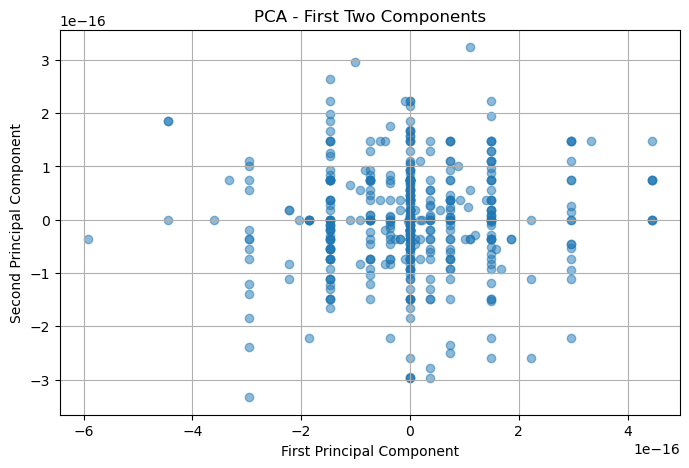

In [68]:


# Create a scatter plot of the first two components
pca_features = np.array(pca_features)

plt.figure(figsize=(8, 5))
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA - First Two Components')
plt.grid(True)
plt.show()


## <i>-- Variance Explained by each Component</i>

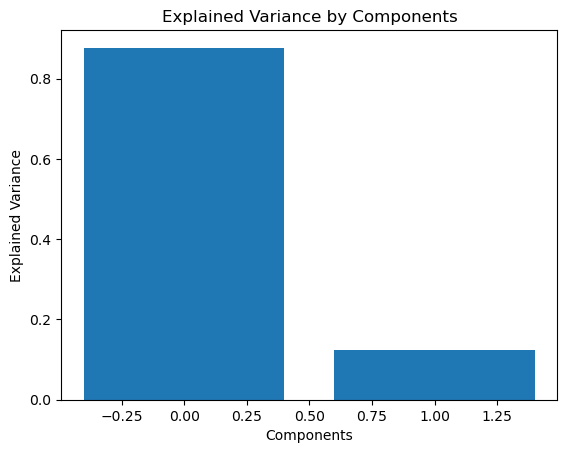

In [69]:
#Average explained variance across all windows
average_explained_variances = np.mean(explained_variances, axis=0)

# Plotting
plt.bar(range(len(average_explained_variances)), average_explained_variances)
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()






In [70]:
print(len(pca_features))

455


#  2.4 Anomaly Detection
### -- <i>Using OneClass SVM with PCA to detect anomaly</i>

In [71]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

# Train the One-Class SVM on PCA features
clfs = OneClassSVM(kernel='rbf', nu=0.03).fit(pca_features)

# Predictions (this assumes you have labels for evaluation)
predss = clfs.predict(pca_features)
print(predss)


[ 1  1  1  1  1  1  1 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1
  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1
  1 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [72]:
onecount=0
onenegcount=0
for i in predss:
    if i == 1:
        onecount+=1
    if i == -1:
        onenegcount+=1
print(onecount)
print(onenegcount)

411
44


### -- <i>Visualizing the predictions to compare with the reference and original data</i>

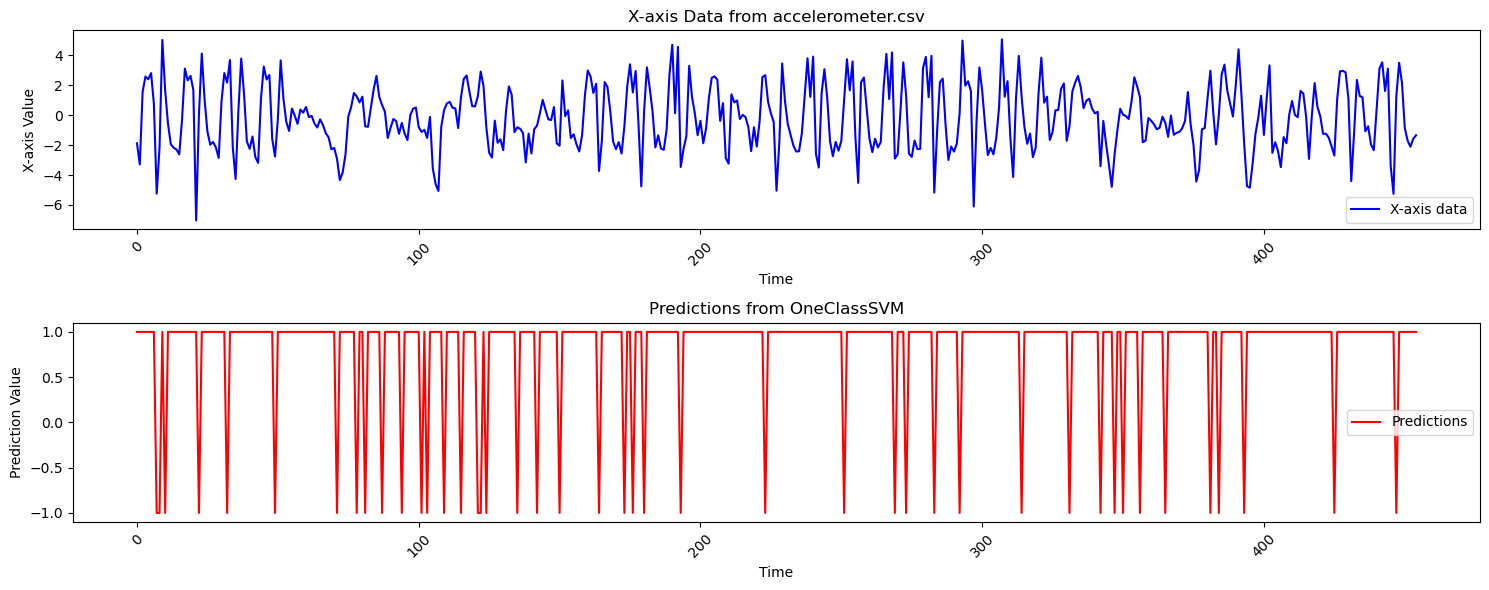

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("accelerometer.csv")

data = data.iloc[:-2]


# Plotting x-axis data
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(range(455), data['x_value'], label='X-axis data', color='blue')
plt.title("X-axis Data from accelerometer.csv")
plt.xlabel("Time")
plt.ylabel("X-axis Value")
plt.xticks(rotation=45)
plt.legend()

# Plotting predictions
plt.subplot(2, 1, 2)
plt.plot(range(455), predss, label='Predictions', color='red')
plt.title("Predictions from OneClassSVM")
plt.xlabel("Time")
plt.ylabel("Prediction Value")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


### -- <i>Using OneClass SVM with PCA and DTW to detect anomaly</i>

In [74]:
# Combine PCA and DTW features
combined_features = np.hstack((pca_features, dtw_features))

# Train the One-Class SVM on combined features
clf_with_dtws = OneClassSVM(kernel='rbf', nu=0.03).fit(combined_features)

# Predictions
preds_with_dtws = clf_with_dtws.predict(combined_features)
print(preds_with_dtws)


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [75]:
onecount=0
onenegcount=0
for i in preds_with_dtws:
    if i == 1:
        onecount+=1
    if i == -1:
        onenegcount+=1
print(onecount)
print(onenegcount)

442
13


### -- <i>Visualizing the predictions to compare with the reference and original data</i>

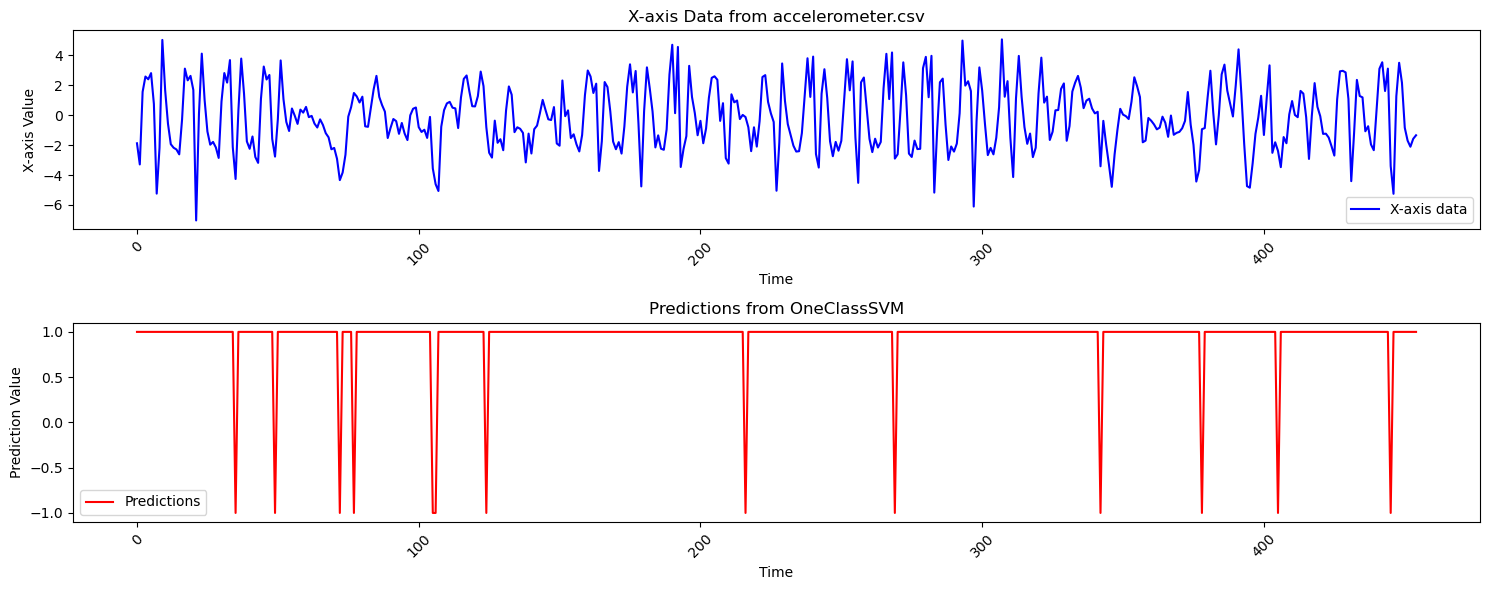

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("accelerometer.csv")


data = data.iloc[:-2]


# Plotting x-axis data
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(range(455), data['x_value'], label='X-axis data', color='blue')
plt.title("X-axis Data from accelerometer.csv")
plt.xlabel("Time")
plt.ylabel("X-axis Value")
plt.xticks(rotation=45)
plt.legend()

# Plotting predictions
plt.subplot(2, 1, 2)
plt.plot(range(455), preds_with_dtws, label='Predictions', color='red')
plt.title("Predictions from OneClassSVM")
plt.xlabel("Time")
plt.ylabel("Prediction Value")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
